In [1]:
import os, re
import numpy as np
import statistics

from glob import glob
from tqdm import tqdm

from skimage import (
    filters, 
    measure,
    morphology, 
    img_as_ubyte,
    io)

from skimage.io import imsave, imread_collection

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.transform import resize

from scipy import ndimage as ndi
from skimage.color import rgb2gray

In [2]:
def rule_of_three_percent_pixels(arr):

    def co_occurrence(arr):
        unique, counts = np.unique(arr, return_counts=True)

        return dict(zip(unique, counts))

    def ternary(value):
        return 0 if value is None else value

    def binarize_image(arr):
        return arr > filters.threshold_minimum(arr)

    image_coo = co_occurrence(arr)

    true_value = ternary(image_coo.get(True))
    false_value = ternary(image_coo.get(False))

    _100 = false_value + true_value

    return dict({
        'true_pixels': int((true_value * 100) / _100),
        'false_pixels': int((false_value * 100) / _100)
    })

def binarize_image(image):
    return image > filters.threshold_otsu(image)

def plot(arr_images=[], grid=(1, 1), cmap="inferno"):

    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111, nrows_ncols=grid,  axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()  
    
def auto_invert_image_mask(arr):
    img = arr.copy()

    if statistics.mode(img.flatten()):
        img = np.invert(img)

    return img

def find_bighest_cluster_area(clusters):
    regions = measure.regionprops(clusters)

    all_areas = map(lambda item: item.area, regions)

    return max(all_areas)

def find_bighest_cluster(img):

    clusters = auto_invert_image_mask(img)

    clusters = measure.label(clusters, background=0)

    cluster_size = find_bighest_cluster_area(clusters)

    return morphology.remove_small_objects(clusters,
                                         min_size=(cluster_size - 1),
                                         connectivity=8)

def rescale_image(image, scale=255):
    return (image * scale).astype('uint8')

def get_image_area(image):
    return find_bighest_cluster_area(measure.label(image, background=0))

In [3]:
broilers = io.imread_collection("../data_rgb/001/imagens_rgb/*")

In [4]:
def binarize(image):
    tresh = image < filters.threshold_local(image * 2,
                                            block_size=35, 
                                            offset=10)
    
    mask = find_bighest_cluster(auto_invert_image_mask(tresh))
    
    mask = morphology.closing(mask, morphology.square(5))
    
    return ndi.binary_fill_holes(mask)

def as_gray(image): return rescale_image(rgb2gray(image[:,:,:3]))

In [5]:
image_mask = binarize(as_gray(broilers[51]))

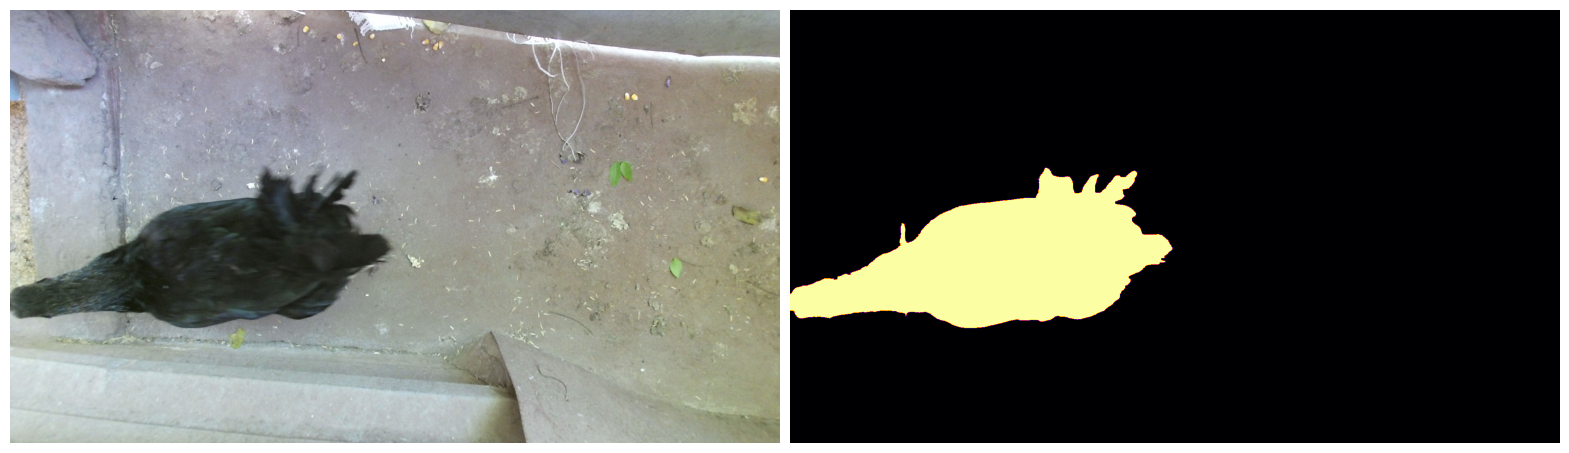

In [6]:
plot([broilers[51], image_mask], (1, 2))

In [7]:
masks= []

for frame in tqdm(broilers):
    
    frame_gray =  as_gray(frame)
    frame_pixel = auto_invert_image_mask(binarize_image(frame_gray))
    
    if rule_of_three_percent_pixels(frame_pixel)['false_pixels'] > 80: #%
        masks.append(binarize(frame_gray))

100%|███████████████████████████████████████████| 72/72 [00:49<00:00,  1.45it/s]


In [8]:
length = np.sqrt(len(masks))
x, y = int(length), int(round(length))

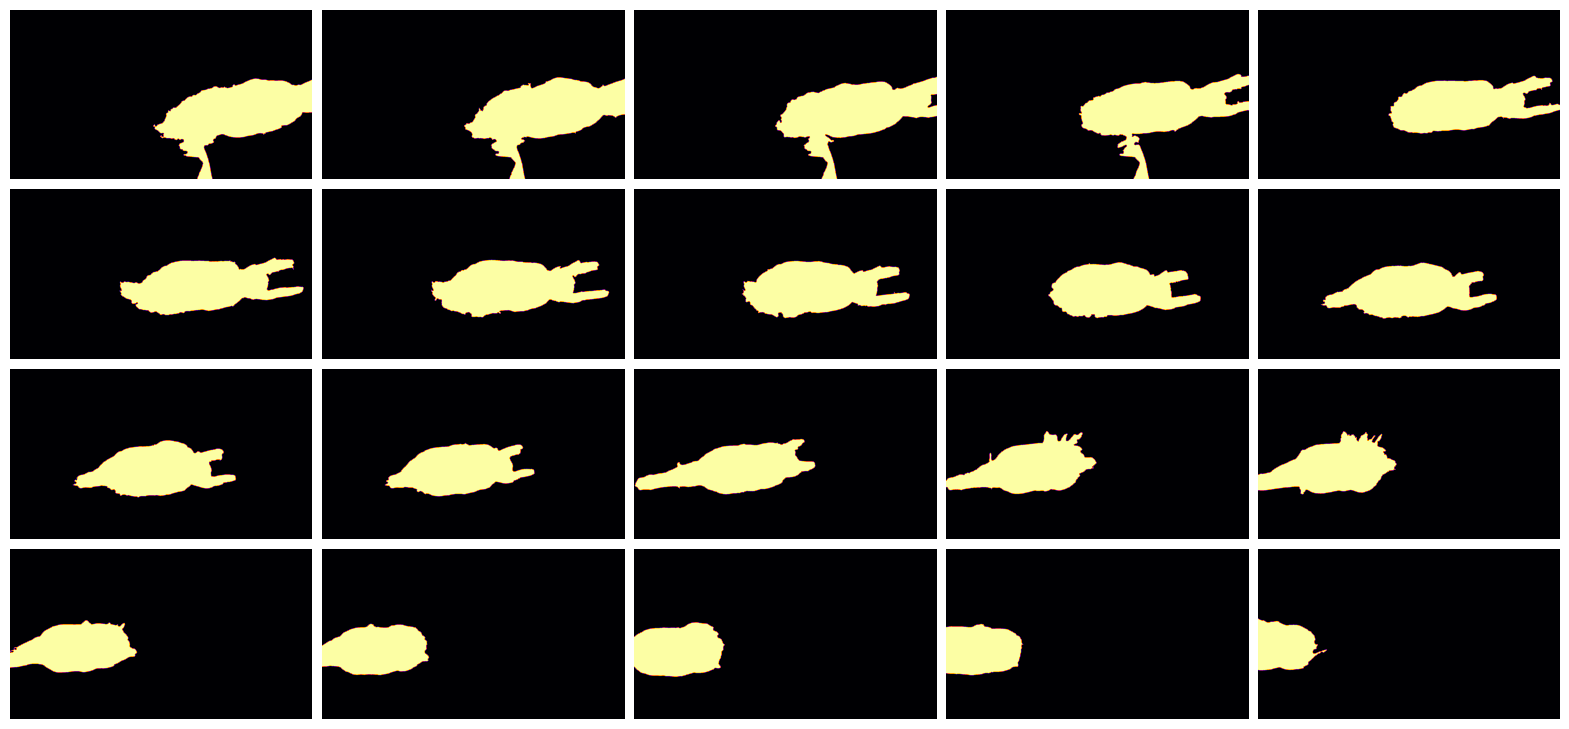

In [9]:
plot(masks, (x, y))

In [10]:
try:
    rgb_destiny_images = 'rgbsT'
    mask_destiny_images = 'masksT'
    os.mkdir(rgb_destiny_images)
    os.mkdir(mask_destiny_images)
except:
    print("Pasta já existe!")

Pasta já existe!


In [20]:
def select_frame_and_save(path):
    

    folder_number, *_ = re.findall(r'\d+', path)
    index = 1
    
    try:
        os.mkdir(f'{mask_destiny_images}/{folder_number}')
        os.mkdir(f'{rgb_destiny_images}/{folder_number}')
    except: pass

    path_frames = f'{path}/*.png'
    back_path, *_ = sorted(glob(path_frames))
    back = as_gray(io.imread(back_path))
    
    for frame in tqdm(io.imread_collection(path_frames)):
        try:

            frame_gray =  as_gray(frame)

            frame_pixel =  binarize(frame_gray ^ back)

            pixels_stats = rule_of_three_percent_pixels(frame_pixel)

            print(":: ", pixels_stats, end=":: \n")

            # Se na imagem tiver 3% de pixels positivos ou mais; então binarizamos a imagem
            if pixels_stats['true_pixels'] >= 3: 

                mask = binarize(frame_gray)

                io.imsave(f'{mask_destiny_images}/{folder_number}/{index}.png', img_as_ubyte(mask))
                io.imsave(f'{rgb_destiny_images}/{folder_number}/{index}.png', frame)

                index += 1
        except: 
            print("Error!")
            continue

In [13]:
for broiler_index in glob('../data_rgb/**/*')[:1]:
    select_frame_and_save(broiler_index)

100%|█████████████████████████████████████████████| 9/9 [00:36<00:00,  4.04s/it]


In [21]:
select_frame_and_save('../data_rgb/001/imagens_rgb')

  1%|▌                                           | 1/72 [00:01<01:51,  1.57s/it]

Error!


  3%|█▏                                          | 2/72 [00:03<02:22,  2.04s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


  4%|█▊                                          | 3/72 [00:06<02:27,  2.14s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


  6%|██▍                                         | 4/72 [00:08<02:30,  2.21s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


  7%|███                                         | 5/72 [00:10<02:28,  2.22s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


  8%|███▋                                        | 6/72 [00:12<02:25,  2.20s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 10%|████▎                                       | 7/72 [00:15<02:27,  2.27s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 11%|████▉                                       | 8/72 [00:17<02:24,  2.26s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 12%|█████▌                                      | 9/72 [00:19<02:20,  2.24s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 14%|█████▉                                     | 10/72 [00:21<02:17,  2.22s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 15%|██████▌                                    | 11/72 [00:24<02:16,  2.25s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 17%|███████▏                                   | 12/72 [00:26<02:15,  2.26s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 


 18%|███████▊                                   | 13/72 [00:28<02:12,  2.25s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 
::  {'true_pixels': 3, 'false_pixels': 96}:: 


 21%|████████▉                                  | 15/72 [00:38<03:07,  3.29s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 22%|█████████▌                                 | 16/72 [00:40<02:48,  3.01s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 24%|██████████▏                                | 17/72 [00:42<02:33,  2.79s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 25%|██████████▊                                | 18/72 [00:45<02:24,  2.67s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 26%|███████████▎                               | 19/72 [00:47<02:15,  2.56s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 28%|███████████▉                               | 20/72 [00:49<02:07,  2.45s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 


 29%|████████████▌                              | 21/72 [00:51<02:01,  2.37s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 31%|█████████████▏                             | 22/72 [00:54<01:58,  2.37s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 32%|█████████████▋                             | 23/72 [00:56<01:54,  2.34s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 33%|██████████████▎                            | 24/72 [00:58<01:50,  2.31s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 35%|██████████████▉                            | 25/72 [01:01<01:48,  2.32s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 36%|███████████████▌                           | 26/72 [01:03<01:46,  2.31s/it]

::  {'true_pixels': 0, 'false_pixels': 99}:: 


 38%|████████████████▏                          | 27/72 [01:05<01:42,  2.28s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 39%|████████████████▋                          | 28/72 [01:07<01:40,  2.27s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 


 40%|█████████████████▎                         | 29/72 [01:10<01:38,  2.30s/it]

::  {'true_pixels': 1, 'false_pixels': 98}:: 


 42%|█████████████████▉                         | 30/72 [01:12<01:36,  2.29s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 
::  {'true_pixels': 3, 'false_pixels': 96}:: 


 43%|██████████████████▌                        | 31/72 [01:19<02:33,  3.75s/it]

::  {'true_pixels': 3, 'false_pixels': 96}:: 


 46%|███████████████████▋                       | 33/72 [01:29<02:35,  4.00s/it]

::  {'true_pixels': 2, 'false_pixels': 97}:: 
::  {'true_pixels': 5, 'false_pixels': 94}:: 


 47%|████████████████████▎                      | 34/72 [01:36<03:07,  4.94s/it]

::  {'true_pixels': 10, 'false_pixels': 89}:: 


 49%|████████████████████▉                      | 35/72 [01:43<03:26,  5.59s/it]

::  {'true_pixels': 17, 'false_pixels': 82}:: 


 50%|█████████████████████▌                     | 36/72 [01:50<03:36,  6.01s/it]

::  {'true_pixels': 16, 'false_pixels': 83}:: 


 51%|██████████████████████                     | 37/72 [01:57<03:40,  6.31s/it]

::  {'true_pixels': 15, 'false_pixels': 84}:: 


 53%|██████████████████████▋                    | 38/72 [02:04<03:41,  6.51s/it]

::  {'true_pixels': 16, 'false_pixels': 83}:: 


 54%|███████████████████████▎                   | 39/72 [02:11<03:39,  6.65s/it]

::  {'true_pixels': 17, 'false_pixels': 82}:: 


 56%|███████████████████████▉                   | 40/72 [02:18<03:35,  6.73s/it]

::  {'true_pixels': 16, 'false_pixels': 83}:: 


 57%|████████████████████████▍                  | 41/72 [02:25<03:30,  6.78s/it]

::  {'true_pixels': 13, 'false_pixels': 86}:: 


 58%|█████████████████████████                  | 42/72 [02:31<03:24,  6.81s/it]

::  {'true_pixels': 17, 'false_pixels': 82}:: 


 60%|█████████████████████████▋                 | 43/72 [02:38<03:19,  6.86s/it]

::  {'true_pixels': 18, 'false_pixels': 81}:: 


 61%|██████████████████████████▎                | 44/72 [02:45<03:12,  6.88s/it]

::  {'true_pixels': 12, 'false_pixels': 87}:: 


 62%|██████████████████████████▉                | 45/72 [02:52<03:07,  6.94s/it]

::  {'true_pixels': 17, 'false_pixels': 82}:: 


 64%|███████████████████████████▍               | 46/72 [02:59<03:00,  6.95s/it]

::  {'true_pixels': 11, 'false_pixels': 88}:: 


 65%|████████████████████████████               | 47/72 [03:06<02:53,  6.94s/it]

::  {'true_pixels': 11, 'false_pixels': 88}:: 


 67%|████████████████████████████▋              | 48/72 [03:13<02:46,  6.93s/it]

::  {'true_pixels': 11, 'false_pixels': 88}:: 


 68%|█████████████████████████████▎             | 49/72 [03:20<02:40,  6.96s/it]

::  {'true_pixels': 9, 'false_pixels': 90}:: 


 69%|█████████████████████████████▊             | 50/72 [03:27<02:33,  6.98s/it]

::  {'true_pixels': 10, 'false_pixels': 89}:: 


 71%|██████████████████████████████▍            | 51/72 [03:34<02:27,  7.01s/it]

::  {'true_pixels': 10, 'false_pixels': 89}:: 


 72%|███████████████████████████████            | 52/72 [03:41<02:19,  6.99s/it]

::  {'true_pixels': 10, 'false_pixels': 89}:: 


 74%|███████████████████████████████▋           | 53/72 [03:48<02:12,  7.00s/it]

::  {'true_pixels': 8, 'false_pixels': 91}:: 


 75%|████████████████████████████████▎          | 54/72 [03:55<02:05,  6.99s/it]

::  {'true_pixels': 8, 'false_pixels': 91}:: 


 76%|████████████████████████████████▊          | 55/72 [04:02<01:58,  7.00s/it]

::  {'true_pixels': 7, 'false_pixels': 92}:: 


 78%|█████████████████████████████████▍         | 56/72 [04:09<01:51,  7.00s/it]

::  {'true_pixels': 6, 'false_pixels': 93}:: 


 79%|██████████████████████████████████         | 57/72 [04:17<01:47,  7.18s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 81%|██████████████████████████████████▋        | 58/72 [04:24<01:40,  7.20s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 82%|███████████████████████████████████▏       | 59/72 [04:32<01:34,  7.26s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 83%|███████████████████████████████████▊       | 60/72 [04:39<01:28,  7.38s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 85%|████████████████████████████████████▍      | 61/72 [04:46<01:20,  7.33s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 86%|█████████████████████████████████████      | 62/72 [04:54<01:13,  7.31s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 88%|█████████████████████████████████████▋     | 63/72 [05:01<01:05,  7.27s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 89%|██████████████████████████████████████▏    | 64/72 [05:08<00:58,  7.30s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 90%|██████████████████████████████████████▊    | 65/72 [05:16<00:51,  7.33s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 92%|███████████████████████████████████████▍   | 66/72 [05:23<00:43,  7.26s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 93%|████████████████████████████████████████   | 67/72 [05:30<00:35,  7.19s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 94%|████████████████████████████████████████▌  | 68/72 [05:37<00:28,  7.17s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 96%|█████████████████████████████████████████▏ | 69/72 [05:44<00:21,  7.12s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 97%|█████████████████████████████████████████▊ | 70/72 [05:51<00:14,  7.05s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


 99%|██████████████████████████████████████████▍| 71/72 [05:58<00:07,  7.09s/it]

::  {'true_pixels': 4, 'false_pixels': 95}:: 


100%|███████████████████████████████████████████| 72/72 [06:05<00:00,  5.08s/it]
